# Classification 

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** We've just learned the framework underlying predictive models---their directed graphical model and MLE objective. We've instantiated this framework for regression---the task of predicting *real-valued* outputs from inputs. Now, we will provide another instantiation: classification. Classification focuses on predicting *categorical-valued* outputs from inputs. 

**Challenge:**

**Outline:**

In [52]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-classification.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Dose,Telekinetic-Control
Patient ID,,,
398,14.421282,0.442779,1
3833,6.857600,0.383581,1
4836,29.038261,0.081084,1
4572,9.198009,0.670395,1
636,50.607525,0.393880,0
2545,4.453116,0.459995,1
1161,42.605614,0.326170,0
2230,46.883350,0.695234,0
148,0.510156,0.536779,0


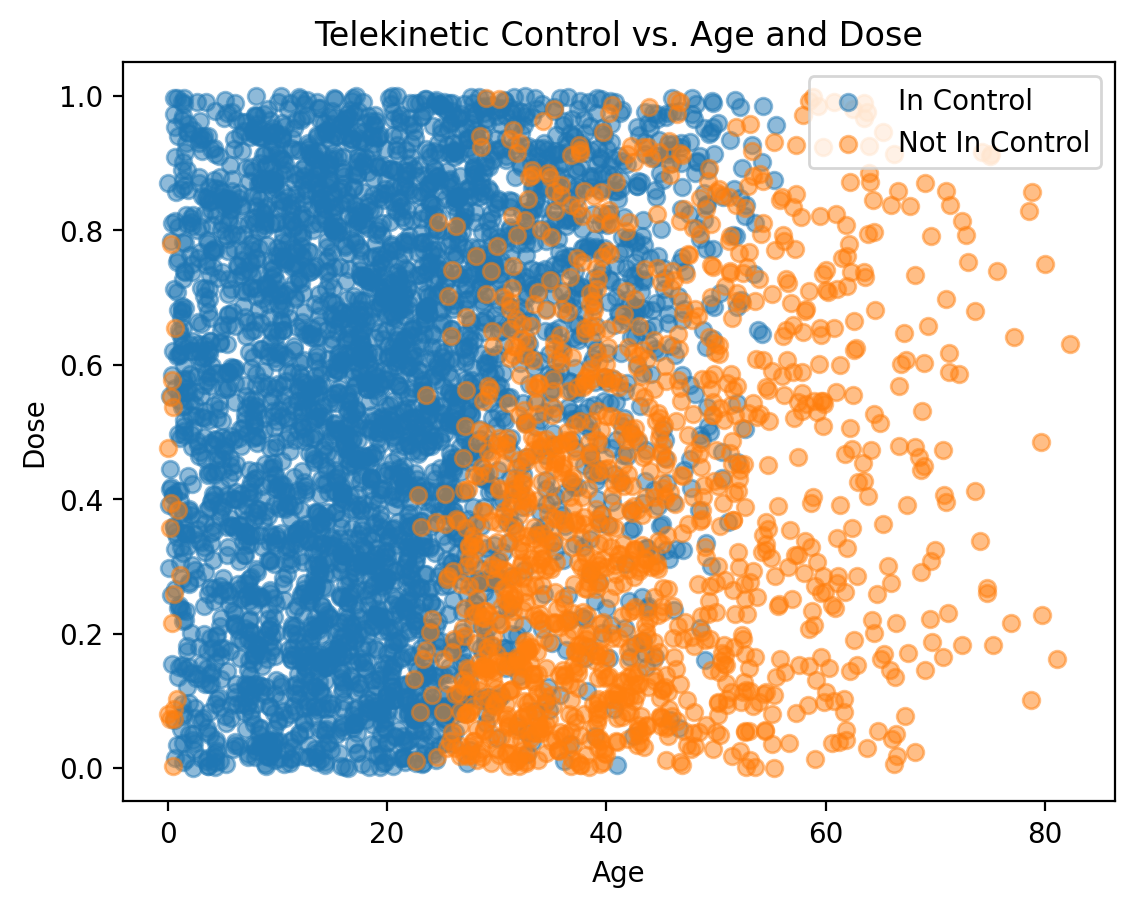

In [53]:
in_control = (data['Telekinetic-Control'] == 1)
plt.scatter(data['Age'][in_control], data['Dose'][in_control], alpha=0.5, label='In Control')
plt.scatter(data['Age'][~in_control], data['Dose'][~in_control], alpha=0.5, label='Not In Control')

plt.xlabel('Age')
plt.ylabel('Dose')
plt.title('Telekinetic Control vs. Age and Dose')

plt.legend()
plt.show()